# Set Environment
Import the libaries need to handle html formats and data tables

In [1]:
import pandas as pd # used to handle dataframes/tables
# used to make plots
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 20 random inputs

The blacklist (bl) and greenscreen (gs) were both made using 20 random inputs. 

Note that the blacklist tool is hard-coded to find blacklist regions in the human genome. Therefore, to account for Arabidopsis having a smaller genome, the line of code that merges significant regions together had to be manually modified to merge regions within 5kb rather than 20kb. 

Greenscreen regions were generated by first running each input sample through MACS2 v2.2.7.1 (—keepdup “auto” —no model –extsize [read length] —broad --nolambda  -g 101274395). Peaks with average q-values (column 9 in the broadPeak output file) above 10-10 were filtered out. Peaks called from the individual inputs were concatenated, and all peaks within a 5kb distance were merged.

In [2]:
#hard code to file paths
gs_file="../data/arabidopsis_greenscreen_20inputs.bed"
bl_file="../data/arabidopsis_blacklist_20inputs.bed"

## Length of masked regions
In the code below we want to make a boxplot to compare the length of regions found by the blacklist and greenscreen methods.

bed and narrowPeak files both contain genome location information. The first 3 columns are mandatory, but the first 6 columns in both file times share the same information.

In [3]:
bed_cols=["chr","start","stop","name","score","strand"]
np_cols=bed_cols+["fc","pval","qval","summit"]

import the greenscreen and blacklist regions into python

In [4]:
gs_df = pd.read_csv(gs_file, header=None, sep="\t")
bl_df = pd.read_csv(bl_file, header=None, sep="\t")

In [5]:
gs_df.columns = np_cols[0:gs_df.shape[1]]
bl_df.columns = np_cols[0:bl_df.shape[1]]
gs_df["mask"]="GS"
bl_df["mask"]="BL"

concatonate the two tables and get the length of each region

In [6]:
as_df = gs_df.append(bl_df)
as_df["len"]=as_df["stop"]-as_df["start"]

create a boxplot comparing the GS and BL regions

/home/sklasfeld/Desktop/Github/GreenscreenProject/env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-7-aa1e8deb262d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


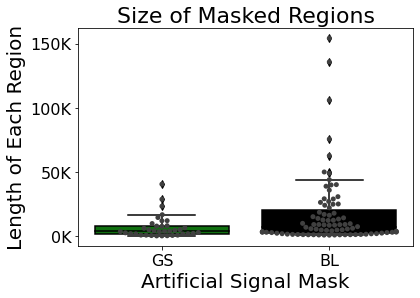

In [7]:
# generate boxplot
ax = sns.boxplot(x="mask", y="len", 
                 palette=sns.color_palette(["green","black"]),
                 data=as_df)
# use swarmplot() to show the data points on top of the box plots
ax = sns.swarmplot(x="mask", y="len", data=as_df, color=".25")
# reformat y-ticks
ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
# set title and x label
ax.set_title('Size of Masked Regions',fontsize=22)
ax.set_xlabel('Artificial Signal Mask',fontsize=20)
ax.set_ylabel('Length of Each Region',fontsize=20)
ax.tick_params(labelsize=16)